# **Face Recognition Project**


---


## Part 2. Face Alignment

In [ ]:
import os
import cv2
from PIL import Image
from skimage import io, transform, color

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader

import random
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from tqdm.notebook import tqdm

sns.set(style="white")

import warnings
warnings.filterwarnings("ignore")

In [ ]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")

device

device(type='cuda')

### **Задача 2. (2 балла)**
 Обучить нейросеть для поиска ключевых точек лица и написать код, который принимает на вход фотографию лица и возвращает выровненное лицо на основе найденных точек (т.е. реализовать вторую часть пайплайна face recognition);

Выберем [датасет](https://www.kaggle.com/datasets/julianlenkiewicz/facialkeypoints68dataset), содержащий изображения с 68 ключевыми точками.

In [ ]:
from google.colab import drive
drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:
! unzip "/content/drive/MyDrive/archive.zip"

- *Обработка данных для 2-ой части пайплайна*

In [ ]:
landmarks_frame = pd.read_csv("./training_frames_keypoints.csv")

n = 25
image_name = landmarks_frame.iloc[n, 0]
image = io.imread(os.path.join("./training", image_name))
landmarks = landmarks_frame.iloc[n, 1:]
landmarks = np.asarray(landmarks, dtype=float).reshape(-1, 2)

print(f"Image name: {image_name}")
print(f"Image shape: {image.shape}")
print(f"Landmarks shape: {landmarks.shape}")

Image name: Alejandro_Toledo_52.jpg
Image shape: (147, 125, 4)
Landmarks shape: (68, 2)


Т.к. кроме изображений у нас есть набор ключевых точек, мы напишем собственные классы для трансформации изображений и соотетствующих им наборов точек.

In [ ]:
class Resize(object):
    """
        Resize the input image to the given size
    """


    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size


    def __call__(self, sample):
        image = sample["image"]
        landmarks = sample["landmarks"]

        h, w = image.shape[:2]

        if isinstance(self.output_size, int):
            if h > w:
                h_new = (self.output_size * h) / w
                w_new = self.output_size
            else:
                h_new = self.output_size
                w_new = (self.output_size * w) / h
        else:
            h_new, w_new = self.output_size

        h_new, w_new = int(h_new), int(w_new)

        image = transform.resize(image, (h_new, w_new))
        landmarks = landmarks * [w_new / w, h_new / h]

        return {
            "image": image,
            "landmarks": landmarks
        }

In [ ]:
class ToTensor(object):
    """
        Convert a ndarray to tensor and scale the values accordingly
    """

    def __call__(self, sample):
        image = sample["image"]
        landmarks = sample["landmarks"]

        image = image.transpose((2, 0, 1))
        image = torch.tensor(image.copy(), dtype=torch.float)

        landmarks = torch.tensor(landmarks, dtype=torch.float)

        return {
            "image": image,
            "landmarks": landmarks
        }

In [ ]:
class RandomHorizontalFlip(object):
    """
        Horizontally flip the given image randomly with the probability 0.5
    """

    def __call__(self, sample):
        image = sample["image"]
        landmarks = sample["landmarks"]

        image_copy = np.copy(image)
        landmarks_copy = np.copy(landmarks)
        landmarks_copy_2 = np.copy(landmarks_copy)

        if random.choice([0, 1]) <= 0.5:
            # horizontally flip image
            image_copy = np.fliplr(image_copy)
            # landmarks (x,y) = (-x,y)
            landmarks_copy[:, 0] = -landmarks_copy[:, 0]
            # move landmarks form 2 kvadrant to 1 kvadrant
            landmarks_copy[:, 0] = landmarks_copy[:, 0] + image_copy.shape[1]

            # since the landmarks are flipped around the y-axis
            # their placement are wrong int the keypoint array.
            # E.g. the right eye and left eye is in the wrong place,
            # so the landmarks need to be correctly mirrored in the list

            landmarks_copy_2 = np.copy(landmarks_copy)

            # mirror jawline
            landmarks_copy_2[16] = landmarks_copy[0]
            landmarks_copy_2[15] = landmarks_copy[1]
            landmarks_copy_2[14] = landmarks_copy[2]
            landmarks_copy_2[13] = landmarks_copy[3]
            landmarks_copy_2[12] = landmarks_copy[4]
            landmarks_copy_2[11] = landmarks_copy[5]
            landmarks_copy_2[10] = landmarks_copy[6]
            landmarks_copy_2[9] = landmarks_copy[7]
            landmarks_copy_2[8] = landmarks_copy[8]
            landmarks_copy_2[7] = landmarks_copy[9]
            landmarks_copy_2[6] = landmarks_copy[10]
            landmarks_copy_2[5] = landmarks_copy[11]
            landmarks_copy_2[4] = landmarks_copy[12]
            landmarks_copy_2[3] = landmarks_copy[13]
            landmarks_copy_2[2] = landmarks_copy[14]
            landmarks_copy_2[1] = landmarks_copy[15]
            landmarks_copy_2[0] = landmarks_copy[16]

            # mirror eyebrows
            landmarks_copy_2[26] = landmarks_copy[17]
            landmarks_copy_2[25] = landmarks_copy[18]
            landmarks_copy_2[24] = landmarks_copy[19]
            landmarks_copy_2[23] = landmarks_copy[20]
            landmarks_copy_2[22] = landmarks_copy[21]
            landmarks_copy_2[21] = landmarks_copy[22]
            landmarks_copy_2[20] = landmarks_copy[23]
            landmarks_copy_2[19] = landmarks_copy[24]
            landmarks_copy_2[18] = landmarks_copy[25]
            landmarks_copy_2[17] = landmarks_copy[26]

            # mirror nose tip
            landmarks_copy_2[35] = landmarks_copy[31]
            landmarks_copy_2[34] = landmarks_copy[32]
            landmarks_copy_2[33] = landmarks_copy[33]
            landmarks_copy_2[32] = landmarks_copy[34]
            landmarks_copy_2[31] = landmarks_copy[35]

            # mirror eyes
            landmarks_copy_2[45] = landmarks_copy[36]
            landmarks_copy_2[44] = landmarks_copy[37]
            landmarks_copy_2[43] = landmarks_copy[38]
            landmarks_copy_2[42] = landmarks_copy[39]
            landmarks_copy_2[47] = landmarks_copy[40]
            landmarks_copy_2[46] = landmarks_copy[41]
            landmarks_copy_2[39] = landmarks_copy[42]
            landmarks_copy_2[38] = landmarks_copy[43]
            landmarks_copy_2[37] = landmarks_copy[44]
            landmarks_copy_2[36] = landmarks_copy[45]
            landmarks_copy_2[41] = landmarks_copy[46]
            landmarks_copy_2[40] = landmarks_copy[47]

            # mirror lips
            landmarks_copy_2[54] = landmarks_copy[48]
            landmarks_copy_2[53] = landmarks_copy[49]
            landmarks_copy_2[52] = landmarks_copy[50]
            landmarks_copy_2[51] = landmarks_copy[51]
            landmarks_copy_2[50] = landmarks_copy[52]
            landmarks_copy_2[49] = landmarks_copy[53]
            landmarks_copy_2[48] = landmarks_copy[54]

            landmarks_copy_2[59] = landmarks_copy[55]
            landmarks_copy_2[58] = landmarks_copy[56]
            landmarks_copy_2[57] = landmarks_copy[57]
            landmarks_copy_2[56] = landmarks_copy[58]
            landmarks_copy_2[55] = landmarks_copy[59]

            landmarks_copy_2[64] = landmarks_copy[60]
            landmarks_copy_2[63] = landmarks_copy[61]
            landmarks_copy_2[62] = landmarks_copy[62]
            landmarks_copy_2[61] = landmarks_copy[63]
            landmarks_copy_2[60] = landmarks_copy[64]

            landmarks_copy_2[67] = landmarks_copy[65]
            landmarks_copy_2[66] = landmarks_copy[66]
            landmarks_copy_2[65] = landmarks_copy[67]

        return {
            "image": image_copy,
            "landmarks": landmarks_copy_2
        }

In [ ]:
class ColorJitter(object):
    """
        ColorJitter image in sample
    """

    def __call__(self, sample):
        image = sample["image"]
        landmarks = sample["landmarks"]

        color_jitter = transforms.ColorJitter(
            brightness=0.3,
            contrast=0.3,
            saturation=0.3,
        )

        image_copy = np.copy(image)
        landmarks_copy = np.copy(landmarks)

        image_copy = color_jitter(Image.fromarray((image_copy * 255).astype(np.uint8)))
        image_copy = np.array(image_copy) / 255.

        return {
            "image": image_copy,
            "landmarks": landmarks_copy
        }

Т.к. на вход модели для поиска ключевых точек будет поступать результат модели для детекции лиц, то напишем класс для обрезки исходных изобраений, чтобы получить лица людей

In [ ]:
class FaceCropTight(object):
    """
        Crop out face using the keypoints as reference
    """

    def __call__(self, sample):
        image = sample["image"]
        landmarks = sample["landmarks"]

        image_copy = np.copy(image)

        h, w = image.shape[:2]

        x_max = 0
        x_min = 10000
        y_max = 0
        y_min = 10000

        # Find the coordinates to landmarks at the far left, far right, top and bottom
        # Also check that no landmarks are outside the image
        for coord in landmarks:
            if coord[0] > x_max:
                if coord[0] >= w:
                    x_max = w
                else:
                    x_max = coord[0]
            if coord[0] < x_min:
                if coord[0] < 0:
                    x_min = 0
                else:
                    x_min = coord[0]
            if coord[1] > y_max:
                if coord[1] >= h:
                    y_max = h
                else:
                    y_max = coord[1]
            if coord[1] < y_min:
                if coord[1] < 0:
                    y_min = 0
                else:
                    y_min = coord[1]

        # Set the left corner landmark as out crop coordinate
        x = int(x_min)
        y = int(y_min)

        # Get height and width of landmark area
        new_h = int(y_max - y_min)
        new_w = int(x_max - x_min)

        # Set the smallest side equal to the largest since we want a square
        if new_h > new_w:
            new_w = new_h
        else:
            new_h = new_w

        randsize1 = [5, 10]

        # Check that padding doesn't go outside the frame
        padding_x_1 = 0
        padding_x_2 = 0
        padding_y_1 = 0
        padding_y_2 = 0

        padding_size_x_1 = random.randint(randsize1[0], randsize1[1])
        padding_size_x_2 = random.randint(randsize1[0], randsize1[1])
        padding_size_y_1 = random.randint(randsize1[0], randsize1[1])
        padding_size_y_2 = random.randint(randsize1[0], randsize1[1])

        if (
            y - padding_size_y_1 > 0
            and x - padding_size_x_1 > 0
            and x + new_w + padding_size_x_2 < w
            and y + new_h + padding_size_y_2 < h
        ):
            padding_x_1 = padding_size_x_1
            padding_x_2 = padding_size_x_2
            padding_y_1 = padding_size_y_1
            padding_y_2 = padding_size_y_2

        image_copy = image_copy[
            y - padding_y_1 : y + new_h + padding_y_2,
            x - padding_x_1 : x + new_w + padding_x_2,
        ]

        landmarks = landmarks - [x - padding_x_1, y - padding_y_1]

        return {
            "image": image_copy,
            "landmarks": landmarks
        }

In [ ]:
class FaceLandmarcksDataset(Dataset):


    def __init__(self, landmarks_frame, root_dir, transform=None):
        self.landmarks_frame = landmarks_frame
        self.root_dir = root_dir
        self.transform = transform


    def __len__(self):
        return len(self.landmarks_frame)


    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        image_name = os.path.join(self.root_dir, self.landmarks_frame.iloc[idx, 0])
        image = io.imread(image_name)
        image = color.rgba2rgb(image)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks], dtype=float).reshape(-1, 2)
        sample = {
            "image": image,
            "landmarks": landmarks
        }

        if self.transform:
            sample = self.transform(sample)

        return sample

In [ ]:
def train_test_split(csv_file: str, split: float):
    landmarks_frame = pd.read_csv(csv_file)
    len_frame = len(landmarks_frame)

    val_split = int(len_frame * split)
    train_split = int(len_frame - val_split)

    val_samples = landmarks_frame.iloc[-val_split:][:]
    train_samples = landmarks_frame.iloc[:train_split][:]

    return train_samples, val_samples

In [ ]:
train_samples, val_samples = train_test_split(csv_file="./training_frames_keypoints.csv", split=0.1)

augmentation = transforms.RandomChoice([
    RandomHorizontalFlip(),
    ColorJitter(),
])

train_dataset = FaceLandmarcksDataset(landmarks_frame=train_samples,
                                      root_dir="./training",
                                      transform=transforms.Compose([
                                          FaceCropTight(),
                                          Resize((224, 224)),
                                          augmentation,
                                          ToTensor()
                                      ]))

val_dataset = FaceLandmarcksDataset(landmarks_frame=val_samples,
                                      root_dir="./training",
                                      transform=transforms.Compose([
                                          FaceCropTight(),
                                          Resize((224, 224)),
                                          ToTensor()
                                      ]))

In [ ]:
batch_size = 32

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)
val_dataloader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

In [ ]:
def show_landmarks(
    image: torch.Tensor,
    orig_landmarks: torch.Tensor = None,
    pred_landmarks: torch.Tensor = None,
    show_legend: bool = False
):
    """
        Show image with landmarks
    """
    image = image.detach().cpu().numpy()
    image = np.transpose(image, (1, 2, 0))

    plt.imshow(image)

    if orig_landmarks is not None:
        orig_landmarks = orig_landmarks.detach().cpu().numpy()
        orig_landmarks = orig_landmarks.reshape(-1, 2)
        plt.scatter(orig_landmarks[:, 0], orig_landmarks[:, 1], s=10, marker=".", c="r", label="original")

    if pred_landmarks is not None:
        pred_landmarks = pred_landmarks.detach().cpu().numpy()
        pred_landmarks = pred_landmarks.reshape(-1, 2)
        plt.scatter(pred_landmarks[:, 0], pred_landmarks[:, 1], s=10, marker=".", c="b", label="predicted")

    if show_legend:
        plt.legend()

    plt.axis("off")

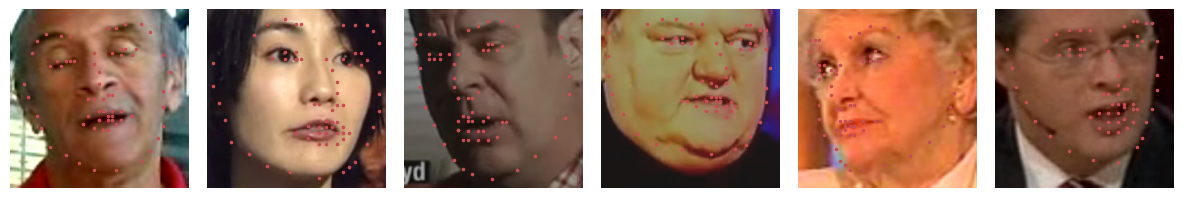

In [ ]:
batch_samples = next(iter(train_dataloader))
batch_images = batch_samples["image"]
batch_landmarks = batch_samples["landmarks"]

fig = plt.figure(figsize=(12, 12))

for i, sample in enumerate(zip(batch_images, batch_landmarks)):
    ax = plt.subplot(1, 6, i + 1)
    show_landmarks(image=sample[0], orig_landmarks=sample[1])
    plt.tight_layout()

    if i == 5:
        plt.show()
        break


Снова возьмем предобученную на датасете ImageNet модель ResNet34

In [ ]:
! pip install pretrainedmodels

In [ ]:
import pretrainedmodels

In [ ]:
class ResNetFaceLandmarks(nn.Module):


    def __init__(self, pretrained, requires_grad):
        super(ResNetFaceLandmarks, self).__init__()

        if pretrained == True:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained="imagenet")
        else:
            self.model = pretrainedmodels.__dict__["resnet34"](pretrained=None)

        if requires_grad == True:
            for param in self.model.parameters():
                param.requires_grad = True
        elif requires_grad == False:
            for param in self.model.parameters():
                param.requires_grad = False

        self.l0 = nn.Linear(in_features=512, out_features=136)


    def forward(self, x):
        batch_size, _, _, _ = x.shape
        x = self.model.features(x)
        x = F.adaptive_avg_pool2d(x, 1).reshape(batch_size, -1)
        l0 = self.l0(x)
        return l0

- *Обучим модель для поиска ключевых точек лица*

In [ ]:
class TrainResNetFaceLandmarks():


    def __init__(
        self,
        model: nn.Module,
        n_epochs: int,
        train_dataloader: DataLoader,
        val_dataloader: DataLoader,
        optimizer: optim.Optimizer,
        criterion,
    ):
        self.model = model
        self.n_epochs = n_epochs
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.optimizer = optimizer
        self.criterion = criterion


    def train_epoch(self):
        self.model.train()
        current_loss = 0.0
        processed_images = 0

        for i, samples in enumerate(tqdm(self.train_dataloader)):
            images = samples["image"].to(device)
            landmarks = samples["landmarks"].to(device)
            landmarks = landmarks.view(landmarks.size(0), -1)

            self.optimizer.zero_grad()
            outputs = self.model(images)
            loss = self.criterion(outputs, landmarks)
            loss.backward()
            self.optimizer.step()

            current_loss += loss.item()
            processed_images += images.size(0)

        train_loss = current_loss / processed_images
        return train_loss


    def val_epoch(self, epoch: int):
        self.model.eval()
        current_loss = 0.0
        processed_images = 0

        for i, samples in enumerate(tqdm(self.val_dataloader)):
            images = samples["image"].to(device)
            landmarks = samples["landmarks"].to(device)
            landmarks = landmarks.view(landmarks.size(0), -1)

            outputs = self.model(images)
            loss = self.criterion(outputs, landmarks)

            current_loss += loss.item()
            processed_images += images.size(0)

            if (epoch + 1) % 5 == 0 and i == 0:
                show_landmarks(image=images[0], orig_landmarks=landmarks[0], pred_landmarks=outputs[0], show_legend=True)
                plt.show()

        val_loss = current_loss / processed_images
        return val_loss


    def train(self):
        train_losses = []
        val_losses = []

        for epoch in range(self.n_epochs):
            train_loss = self.train_epoch()
            train_losses.append(train_loss)

            val_loss = self.val_epoch(epoch)
            val_losses.append(val_loss)

            print(f"Epoch {epoch + 1}/{self.n_epochs}: train loss = {train_loss}, val loss = {val_loss}\n")

        return train_losses, val_losses

In [ ]:
lr = 1e-3
n_epochs = 25
criterion = nn.SmoothL1Loss()
resnet_landmarks = ResNetFaceLandmarks(pretrained=True, requires_grad=True).to(device)
optimizer = torch.optim.Adam(resnet_landmarks.parameters(), lr=lr)
train_resnet_landmarks = TrainResNetFaceLandmarks(resnet_landmarks, n_epochs, train_dataloader, val_dataloader, optimizer, criterion)

  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 1/25: train loss = 2.0496356465850165, val loss = 0.9900046332034073



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 2/25: train loss = 0.46052018148449175, val loss = 0.3536518185124921



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 3/25: train loss = 0.26159882270019685, val loss = 0.240271371224023



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 4/25: train loss = 0.21891724726661027, val loss = 0.2156027603700671



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

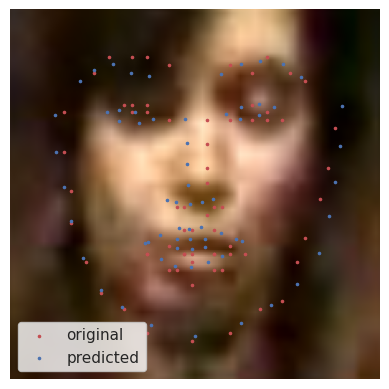

Epoch 5/25: train loss = 0.21153107396445317, val loss = 0.25111002729118215



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 6/25: train loss = 0.19610995077199286, val loss = 0.17886919920155078



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 7/25: train loss = 0.1542415566866756, val loss = 0.14464301732234183



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 8/25: train loss = 0.14214455920710337, val loss = 0.12496691425411688



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 9/25: train loss = 0.13407903833168922, val loss = 0.13769338034480982



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

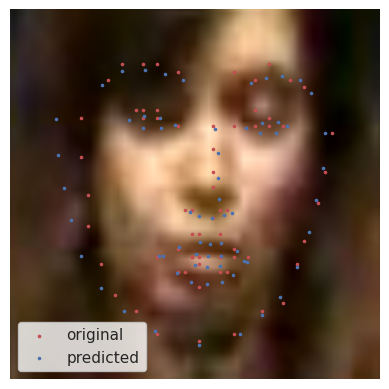

Epoch 10/25: train loss = 0.13066062250859625, val loss = 0.12184877547225512



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 11/25: train loss = 0.1276107538343241, val loss = 0.1294197932833192



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 12/25: train loss = 0.12736851122321152, val loss = 0.11181372989808892



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 13/25: train loss = 0.12346745952868186, val loss = 0.1192671956354483



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 14/25: train loss = 0.11239863650942644, val loss = 0.0967940291917393



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

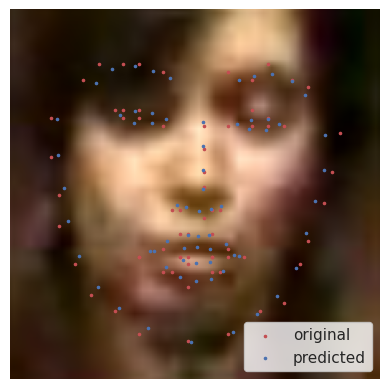

Epoch 15/25: train loss = 0.10661790574469217, val loss = 0.10071433830812487



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 16/25: train loss = 0.10121330546169746, val loss = 0.1203485679075208



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 17/25: train loss = 0.09872073776761742, val loss = 0.09244050249198958



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 18/25: train loss = 0.09540793073957783, val loss = 0.10095555038121394



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 19/25: train loss = 0.09559734680227198, val loss = 0.08772719526566522



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

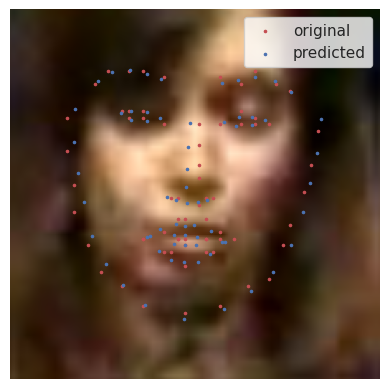

Epoch 20/25: train loss = 0.09509898785296086, val loss = 0.09342933734717397



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 21/25: train loss = 0.0937887043028649, val loss = 0.09732622907340871



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 22/25: train loss = 0.08840965214681565, val loss = 0.0859244248770565



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 23/25: train loss = 0.08601261547196355, val loss = 0.08128285339112916



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

Epoch 24/25: train loss = 0.08447572393809112, val loss = 0.10447300445137686



  0%|          | 0/98 [00:00<?, ?it/s]

  0%|          | 0/11 [00:00<?, ?it/s]

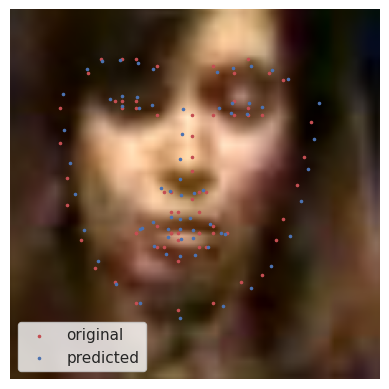

Epoch 25/25: train loss = 0.08560739019562864, val loss = 0.08660744242585464

CPU times: user 4min 17s, sys: 29.8 s, total: 4min 46s
Wall time: 32min 4s


In [ ]:
%%time
train_losses, val_losses = train_resnet_landmarks.train()

In [ ]:
def plot_loss(
    train_losses: list[float],
    val_losses: list[float]
):
      """
          Show train and validation losses
      """
      fig, ax = plt.subplots(figsize=(8, 6))

      ax.plot(train_losses, label="Train losses")
      ax.plot(val_losses, label="Val losses")
      ax.set_xticks(np.arange(0, n_epochs + 1))
      ax.set_xlabel("Epoch")
      ax.set_ylabel("Loss")
      ax.legend()

      plt.show()

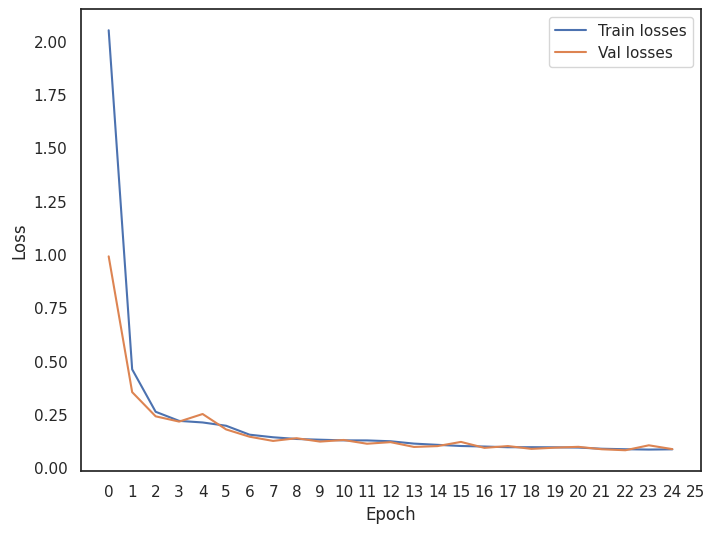

In [ ]:
plot_loss(train_losses, val_losses)

Заново создадим датасет из первой части, чтобы посмотреть как работает обученная модель на представленных данных

In [ ]:
! pip3 install wldhx.yadisk-direct

In [ ]:
! yadisk-direct https://disk.yandex.ru/d/S8f03spLIA1wrw

https://downloader.disk.yandex.ru/disk/a9f6c43dce81d824851fe802c6524c9d5292f170424f2cadd24c2af471163cdb/668ef1fe/aZ8Akc9CqtcaAMvg9MkExUmNfU9U_vPugtmtwAC7LCh7Ob4GqD-JrqJl2rsy_hxC-1lho6HNKGxRJzyaqhvCBg%3D%3D?uid=0&filename=celebA_train_500.zip&disposition=attachment&hash=PKVHlR%2B3q03Ys8aOKp5s/dgbI1MoVhGrKn/oCUbHWox44FxZCGQEdyLSePCIwi7Tq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=316082386&fsize=170342993&hid=8e5296bb80b8febc2b500d8fd890bbcf&media_type=compressed&tknv=v2


In [ ]:
! wget "https://downloader.disk.yandex.ru/disk/a9f6c43dce81d824851fe802c6524c9d5292f170424f2cadd24c2af471163cdb/668ef1fe/aZ8Akc9CqtcaAMvg9MkExUmNfU9U_vPugtmtwAC7LCh7Ob4GqD-JrqJl2rsy_hxC-1lho6HNKGxRJzyaqhvCBg%3D%3D?uid=0&filename=celebA_train_500.zip&disposition=attachment&hash=PKVHlR%2B3q03Ys8aOKp5s/dgbI1MoVhGrKn/oCUbHWox44FxZCGQEdyLSePCIwi7Tq/J6bpmRyOJonT3VoXnDag%3D%3D%3A&limit=0&content_type=application%2Fzip&owner_uid=316082386&fsize=170342993&hid=8e5296bb80b8febc2b500d8fd890bbcf&media_type=compressed&tknv=v2" -O celebA.zip
! unzip celebA.zip

In [ ]:
def get_paths(dataset_type="train"):
    f = open("./celebA_train_500/celebA_train_split.txt", "r")
    image_labels = f.readlines()
    f.close()

    labels = {
        "train": 0,
        "val": 1,
        "test": 2,
    }

    image_labels = [item.strip().split() for item in image_labels]
    images = [item[0] for item in image_labels if int(item[1]) == labels[dataset_type]]

    image_paths = []
    for image in images:
        image_paths.append(os.path.join("./celebA_train_500/celebA_imgs/", image))

    return image_paths

In [ ]:
class celebADataset(Dataset):


    def __init__(
        self,
        dataset_type: str = "train",
        crop_images: bool = False,
        transform=None
    ):
        super().__init__()

        self.dataset_type = dataset_type
        self.crop_images = crop_images
        self.transform = transform
        self.image_paths = get_paths(self.dataset_type)

        f = open("./celebA_train_500/celebA_anno.txt", "r")
        image_labels = f.readlines()
        f.close()

        image_labels = [item.strip().split() for item in image_labels]
        image_labels = {image: int(label) for image, label in image_labels}

        self.image_labels = [int(image_labels[path.split("/")[-1]]) for path in self.image_paths]


    def __len__(self):
        return len(self.image_paths)


    def load_sample(self, file):
        image = Image.open(file)

        if self.crop_images:
            image = np.array(image)
            image = Image.fromarray(image[77:-41, 45:-50])

        return image


    def __getitem__(self, index):
        image_path = self.image_paths[index]
        image_label = self.image_labels[index]

        image = self.load_sample(image_path)
        if self.transform:
            image = self.transform(image)

        return image, image_label

In [ ]:
test_val_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
])

celeba_test_dataset = celebADataset(dataset_type="test", crop_images=True, transform=test_val_transform)

In [ ]:
batch_size = 32

celeba_test_dataloader = DataLoader(celeba_test_dataset, batch_size=batch_size, shuffle=False, num_workers=2)

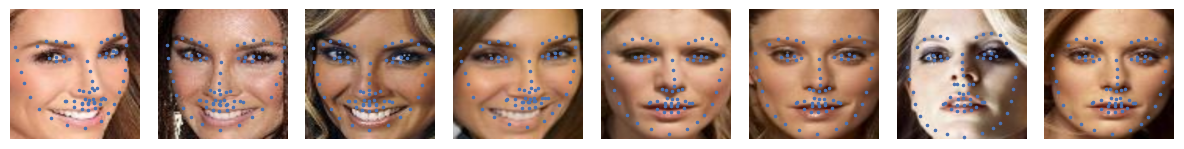

In [ ]:
images, lables = next(iter(celeba_test_dataloader))

fig = plt.figure(figsize=(12, 12))

for i, image in enumerate(images):
    ax = plt.subplot(1, 8, i + 1)

    resnet_landmarks.eval()
    with torch.no_grad():
        pred_landmarks = resnet_landmarks(torch.unsqueeze(image, 0).to(device))

    show_landmarks(image=image, pred_landmarks=pred_landmarks)
    plt.tight_layout()

    if i == 7:
        plt.show()
        break


- *Сохраним веса модели*

In [ ]:
torch.save(resnet_landmarks.state_dict(), "./resnet_landmarks.pt")

- *Создадим класс для выравнивания лица*

In [ ]:
class FaceAligner:


    def __init__(
        self,
        predictor: nn.Module,
        desired_left_eye = (0.32, 0.32),
        desired_face_width = 224,
        desired_face_height = 224
        ):
        self.predictor = predictor
        self.desired_left_eye = desired_left_eye
        self.desired_face_width = desired_face_width
        self.desired_face_height = desired_face_height


    def align(self, image):
        pred_landmarks = self.predictor(image.to(device))

        pred_landmarks = torch.squeeze(pred_landmarks.detach().cpu()).numpy()
        image = torch.squeeze(image.detach().cpu()).numpy()

        image = np.transpose(image, (1, 2, 0))
        pred_landmarks = pred_landmarks.reshape(-1, 2)

        # select the points of the left and right eyes
        left_eye_landmarks = pred_landmarks[36:42]
        right_eye_landmarks = pred_landmarks[42:48]

        # calculate the center of mass for each eye
        left_eye_center = left_eye_landmarks.mean(axis=0)
        right_eye_center = right_eye_landmarks.mean(axis=0)

        # calculate the coordinates of the central point between the eyes
        eyes_center = ((left_eye_center[0] + right_eye_center[0]) / 2, (left_eye_center[1] + right_eye_center[1]) / 2)

        # calculate the angle between the centers of the eyes
        dy = right_eye_center[1] - left_eye_center[1]
        dx = right_eye_center[0] - left_eye_center[1]
        angle = np.degrees(np.arctan2(dy, dx)) + 360

        # calculate the x-coordinate of the right eye
        # based on the desired x-coordinate of the left eye
        desired_right_eye_x = 1.0 - self.desired_left_eye[0]

        # calculating the scale of the new image
        dist = np.sqrt((dx ** 2) + (dy ** 2))
        desired_dist = (desired_right_eye_x - self.desired_left_eye[0]) * self.desired_face_width
        scale = desired_dist / dist

        M = cv2.getRotationMatrix2D(eyes_center, angle, scale)

        tx = self.desired_face_width * 0.5
        ty = self.desired_face_height * self.desired_left_eye[1]
        M[0, 2] += (tx - eyes_center[0])
        M[1, 2] += (ty - eyes_center[1])

        (w, h) = (self.desired_face_width, self.desired_face_height)
        output = cv2.warpAffine(image, M, (w, h), flags=cv2.INTER_CUBIC)
        output = torch.FloatTensor(np.clip(output, 0, 1).transpose((2, 0, 1)))

        return output

In [ ]:
face_aligner = FaceAligner(predictor=resnet_landmarks)

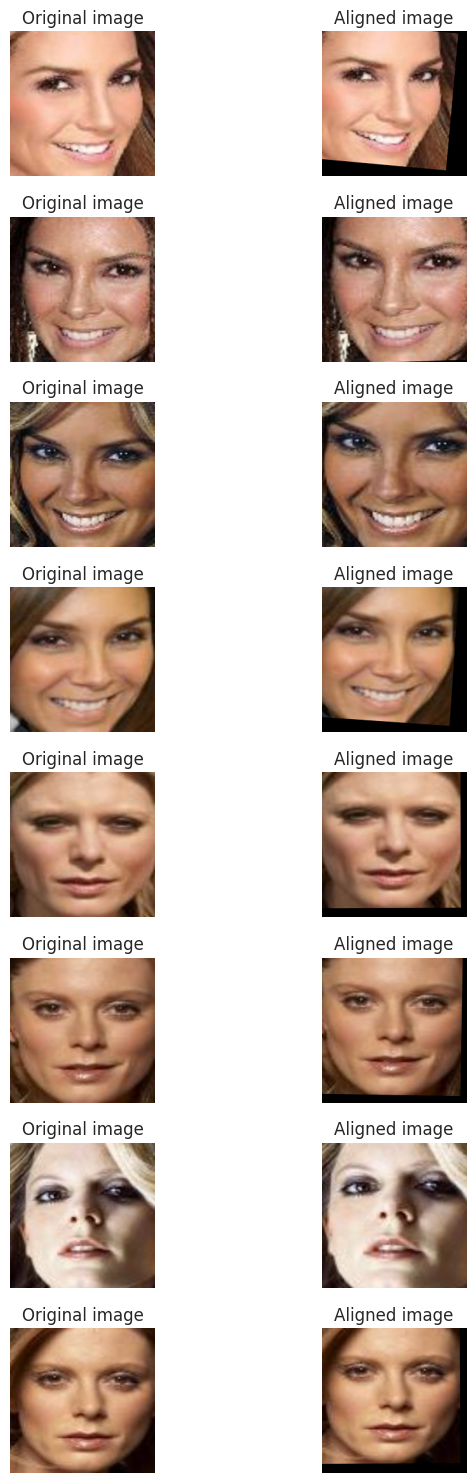

In [ ]:
batch_samples = next(iter(celeba_test_dataloader))
batch_images = batch_samples[0]

nrows = 8; ncols=2
fig = plt.figure(figsize=(8, 15));

for i, image in enumerate(batch_images):
    plt.subplot(nrows, ncols, i * ncols + 1)
    plt.imshow(image.permute((1, 2, 0)).numpy())
    plt.title("Original image")
    plt.axis("off")

    plt.subplot(nrows, ncols, i * ncols + 2)
    output = face_aligner.align(torch.unsqueeze(image, 0))
    plt.imshow(output.detach().cpu().numpy().transpose((1, 2, 0)))
    plt.title("Aligned image")
    plt.axis("off")

    if i == 7:
        plt.tight_layout()
        plt.show();
        break